In [ ]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random
from faker import Faker
import matplotlib.pyplot as plt

# Seed for reproducibility
random.seed(42)
np.random.seed(42)

NUM_RECORDS = 10000
ANOMALY_PERCENT = 0.05
NULL_PERCENT = 0.05
REPEAT_PERCENT = 0.05

faker = Faker()

# Function to generate 1 transaction
def generate_transaction(i):
    return {
        "transaction_id": i + 1,
        "customer_id": random.randint(1000, 9999),
        "account_no": random.randint(10**9, 10**10 - 1),
        "channel": random.choice(["Online", "ATM", "Branch", "Mobile", "UPI", "Purchase","Bill Payment"]),
        "transaction_amount": random.randint(10, 5000),  # integer amount
        "payee_account_no": random.randint(10**9, 10**10 - 1),
        "transaction_type": random.choice(["Credit", "Debit"]),
        "currency_code": random.choice(["USD", "EUR", "GBP"]),
        "country_code": random.choice(["US", "GB", "DE", "FR"]),
        "location": faker.city(),
        "account_type": random.choice(["Savings", "Current", "Loan"]),
        "transaction_time": faker.date_time_this_year(),
        "account_status": random.choice(["Active", "Suspended"]),
        "customer_address": faker.address(),
        "is_anomaly": 0
    }

# Generate the base dataset
data = [generate_transaction(i) for i in range(NUM_RECORDS)]
df = pd.DataFrame(data)

# Inject 5% anomalies by multiplying amount
num_anomalies = int(NUM_RECORDS * ANOMALY_PERCENT)
anomaly_indices = np.random.choice(df.index, size=num_anomalies, replace=False)
df.loc[anomaly_indices, "transaction_amount"] = df.loc[anomaly_indices, "transaction_amount"] * 20
df.loc[anomaly_indices, "is_anomaly"] = 1

# Inject 5% nulls randomly into selected columns
num_nulls = int(NUM_RECORDS * NULL_PERCENT)
for col in ["channel", "currency_code", "location"]:
    null_indices = np.random.choice(df.index, size=num_nulls, replace=False)
    df.loc[null_indices, col] = None

# Repeat 5% of anomalous customers
anomalous_customers = df.loc[anomaly_indices, "customer_id"].unique()
repeats = df[df["customer_id"].isin(anomalous_customers)].sample(frac=REPEAT_PERCENT, replace=True, random_state=42)
df = pd.concat([df, repeats]).reset_index(drop=True)

# Ensure amounts are integers
df["transaction_amount"] = df["transaction_amount"].astype(int)

# Save to CSV
df.to_csv("bank_transactions_integer.csv", index=False)
print("✅ Dataset saved as bank_transactions_integer.csv")


✅ Dataset saved as bank_transactions_integer.csv


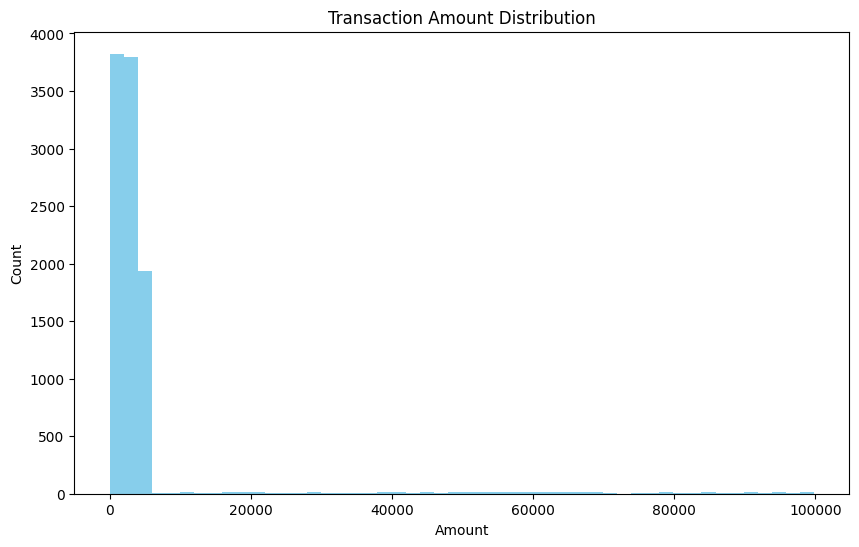

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(df["transaction_amount"], bins=50, color="skyblue")
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()


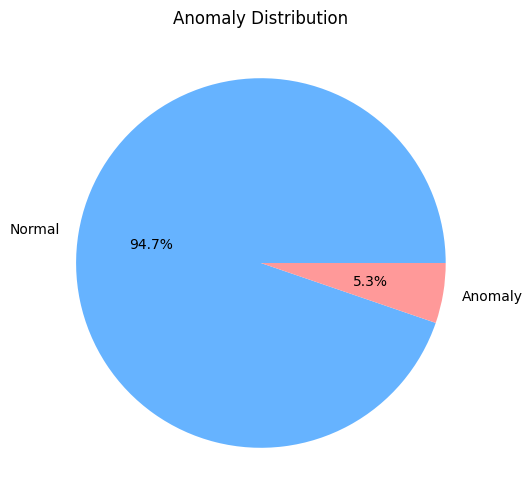

In [ ]:
plt.figure(figsize=(6,6))
df["is_anomaly"].value_counts().plot.pie(autopct='%1.1f%%', labels=["Normal","Anomaly"], colors=["#66b3ff","#ff9999"])
plt.title("Anomaly Distribution")
plt.ylabel("")
plt.show()


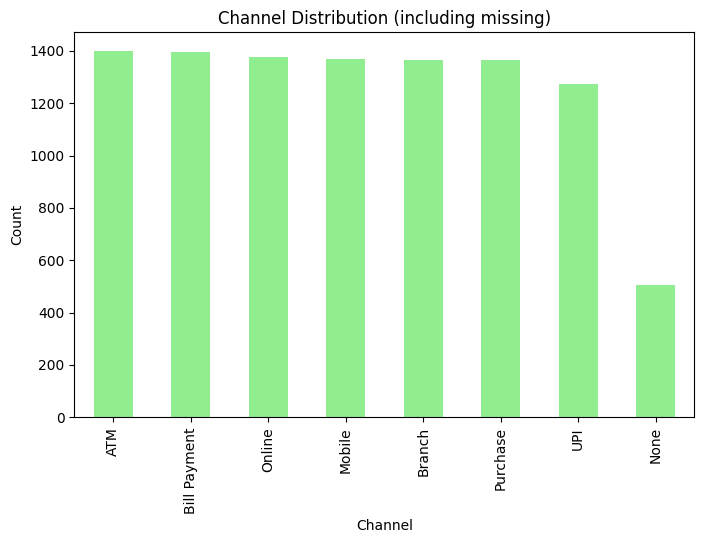

In [ ]:
plt.figure(figsize=(8,5))
df["channel"].value_counts(dropna=False).plot.bar(color="lightgreen")
plt.title("Channel Distribution (including missing)")
plt.xlabel("Channel")
plt.ylabel("Count")
plt.show()


**Preprocessing**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/content/bank_transactions_integer.csv", parse_dates=["transaction_time"])

print("✅ Data Loaded. Shape:", df.shape)

# Display initial few rows
display(df.head())

# Fill missing values
# For 'channel', 'currency_code', 'location'
for col in ["channel", "currency_code", "location"]:
    df[col].fillna("Unknown", inplace=True)

# Encode categorical columns
categorical_cols = [
    "channel",
    "transaction_type",
    "currency_code",
    "country_code",
    "location",
    "account_type",
    "account_status"
]
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("✅ Categorical columns encoded.")

# Scale numeric columns
numeric_cols = [
    "transaction_amount",
    "customer_id",
    "account_no",
    "payee_account_no"
]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])

# Create DataFrame with scaled columns
scaled_df = pd.DataFrame(
    scaled_data,
    columns=[f"{col}_scaled" for col in numeric_cols]
)

# Concatenate scaled columns back
df = pd.concat([df, scaled_df], axis=1)

print("✅ Numeric columns scaled.")

# Save preprocessed dataset
df.to_csv("/content/preprocessed_transactions.csv", index=False)
print("✅ Preprocessed dataset saved to /content/preprocessed_transactions.csv")

# Display preprocessing statistics
stats = df[numeric_cols + [f"{col}_scaled" for col in numeric_cols]].describe().T
display(stats)


✅ Data Loaded. Shape: (10050, 15)


,transaction_id,customer_id,account_no,channel,transaction_amount,payee_account_no,transaction_type,currency_code,country_code,location,account_type,transaction_time,account_status,customer_address,is_anomaly
0,1,2824,9697354961,Branch,2016,1958682846,Credit,GBP,US,South Stevenville,Loan,2025-07-03 04:55:51.752918,Suspended,"370 Raymond Glens\nLake Ashleymouth, ID 78490",0
1,2,1520,1127978094,ATM,1915,9703905715,Credit,GBP,FR,Rodriguezchester,Savings,2025-05-07 15:29:21.777771,Suspended,"296 Daniel Springs Apt. 232\nLake Ronaldland, ...",0
2,3,5557,4460967357,Purchase,3472,6756332150,Credit,USD,DE,New Marktown,Savings,2025-05-25 13:12:29.506938,Active,"532 Vazquez Knolls\nSmithhaven, NV 75204",0
3,4,7224,5710360983,Bill Payment,56540,7887950851,Credit,GBP,FR,Masonstad,Loan,2025-05-02 20:21:45.958824,Active,"74014 Conner Causeway\nNatashahaven, CO 06018",1
4,5,7201,9928378856,Branch,2972,3479708607,Credit,USD,GB,Lake Michaelbury,Current,2025-03-26 14:33:16.790143,Active,"634 Reed Stream Apt. 106\nNew Tanya, IA 98544",0


✅ Categorical columns encoded.
✅ Numeric columns scaled.


/tmp/ipython-input-7-3233341345.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("Unknown", inplace=True)


✅ Preprocessed dataset saved to /content/preprocessed_transactions.csv


,count,mean,std,min,25%,50%,75%,max
transaction_amount,10050.0,5.011390e+03,1.256185e+04,1.000000e+01,1.299000e+03,2.642000e+03,3.959750e+03,9.982000e+04
customer_id,10050.0,5.503622e+03,2.613869e+03,1.000000e+03,3.215000e+03,5.539500e+03,7.761000e+03,9.999000e+03
account_no,10050.0,5.492442e+09,2.598942e+09,1.000678e+09,3.236425e+09,5.483599e+09,7.732504e+09,9.999496e+09
payee_account_no,10050.0,5.478053e+09,2.595323e+09,1.004484e+09,3.231908e+09,5.427403e+09,7.727925e+09,9.999214e+09
transaction_amount_scaled,10050.0,-1.626118e-17,1.000050e+00,-3.981612e-01,-2.955437e-01,-1.886274e-01,-8.372117e-02,7.547723e+00
customer_id_scaled,10050.0,6.645872e-17,1.000050e+00,-1.723057e+00,-8.756123e-01,1.372685e-02,8.636589e-01,1.719904e+00
account_no_scaled,10050.0,-1.725099e-16,1.000050e+00,-1.728391e+00,-8.680955e-01,-3.402765e-03,8.619558e-01,1.734274e+00
payee_account_no_scaled,10050.0,1.760449e-16,1.000050e+00,-1.723790e+00,-8.655016e-01,-1.951668e-02,8.669380e-01,1.742128e+00


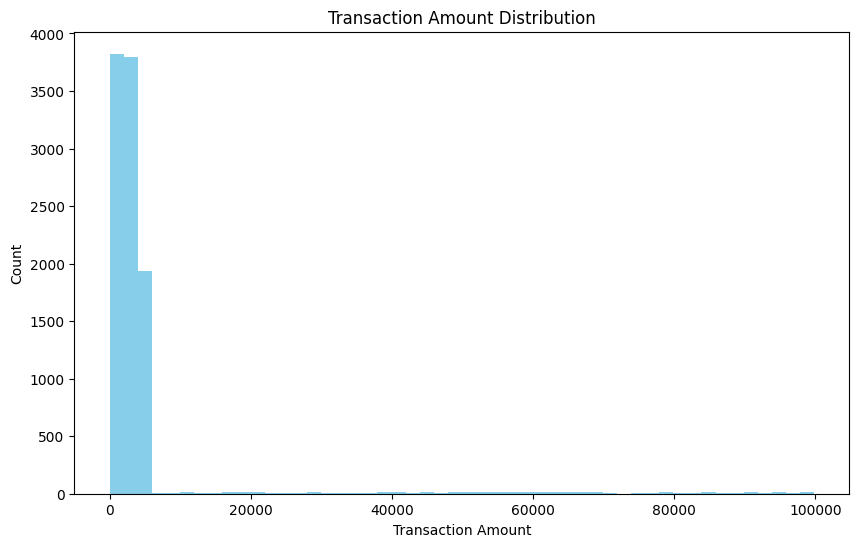

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(df["transaction_amount"], bins=50, color="skyblue")
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.show()



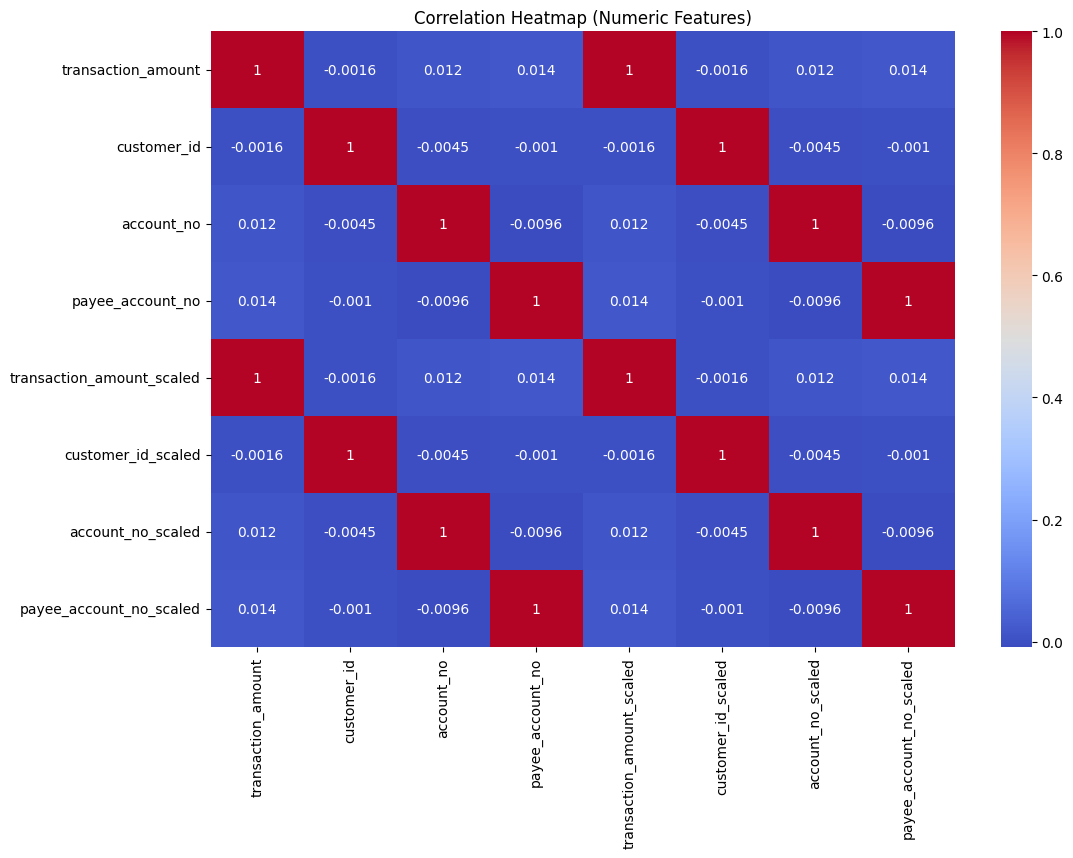

In [ ]:
corr_cols = numeric_cols + [f"{col}_scaled" for col in numeric_cols]

plt.figure(figsize=(12,8))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


**Feature engineering**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
df = pd.read_csv("/content/preprocessed_transactions.csv", parse_dates=["transaction_time"])
print("✅ Data loaded. Shape:", df.shape)

# Sort by customer and time
df.sort_values(["customer_id", "transaction_time"], inplace=True)

# ================================
# 1️⃣ Geolocation & Country Features
# ================================
# Mark high-risk countries
high_risk_country_codes = [3]  # e.g., 'NG' encoded as 3
df["is_high_risk_country"] = df["country_code"].isin(high_risk_country_codes).astype(int)

# ================================
# 2️⃣ Device & Channel Features
# ================================
# One-hot encode channel (or keep label encoding from preprocessing)
# Here we keep label encoding

# Frequency of transactions per channel per customer
df["channel_frequency"] = df.groupby(["customer_id", "channel"])["transaction_id"].transform("count")

# Is new channel for this customer
df["is_new_channel"] = (~df.duplicated(subset=["customer_id", "channel"])).astype(int)

# ================================
# 3️⃣ Customer Behaviour Profiles
# ================================
# Average transaction amount per customer
df["avg_txn_amount_customer"] = df.groupby("customer_id")["transaction_amount"].transform("mean")

# Transaction amount deviation
df["txn_amount_deviation"] = df["transaction_amount"] - df["avg_txn_amount_customer"]

# Transaction counts per customer
df["customer_txn_count"] = df.groupby("customer_id")["transaction_id"].transform("count")

# Most frequent transaction hour per customer
df["hour"] = df["transaction_time"].dt.hour
most_common_hours = (
    df.groupby("customer_id")["hour"].agg(lambda x: x.value_counts().index[0])
    .to_dict()
)
df["most_common_hour"] = df["customer_id"].map(most_common_hours)

# ================================
# 4️⃣ Risk Flags / Rule-based Features
# ================================
# Large transaction flag
df["is_large_txn"] = (df["transaction_amount"] > 10000).astype(int)

# Night transaction flag
df["is_night_txn"] = df["hour"].isin([0,1,2,3,4,5]).astype(int)

# Suspicious combination
df["is_suspicious_combo"] = (
    df["is_large_txn"] & df["is_night_txn"] & df["is_high_risk_country"]
).astype(int)

# ================================
# 5️⃣ Time Window Aggregates
# ================================
# Initialize new columns
df["txn_count_last_7d"] = 0
df["txn_sum_last_7d"] = 0

# Build dict of transaction times per customer
txn_times = df.groupby("customer_id")["transaction_time"].apply(list).to_dict()
txn_amounts = df.groupby("customer_id")[["transaction_time", "transaction_amount"]].apply(
    lambda x: list(zip(x["transaction_time"], x["transaction_amount"]))
).to_dict()

# Compute rolling 7-day counts and sums
for idx, row in df.iterrows():
    cust_id = row["customer_id"]
    tx_time = row["transaction_time"]

    times = pd.Series(txn_times[cust_id])
    count_7d = ((tx_time - times) <= pd.Timedelta(days=7)).sum() - 1
    df.at[idx, "txn_count_last_7d"] = count_7d

    total_7d = sum(
        amt for t, amt in txn_amounts[cust_id]
        if pd.Timedelta(0) < (tx_time - t) <= pd.Timedelta(days=7)
    )
    df.at[idx, "txn_sum_last_7d"] = total_7d

print("✅ Feature engineering completed.")

# Save feature-engineered data
df.to_csv("/content/feature_engineered_transactions.csv", index=False)
print("✅ Saved to /content/feature_engineered_transactions.csv")

# Display sample rows
df.head()



✅ Data loaded. Shape: (10050, 19)
✅ Feature engineering completed.
✅ Saved to /content/feature_engineered_transactions.csv


,transaction_id,customer_id,account_no,channel,transaction_amount,payee_account_no,transaction_type,currency_code,country_code,location,...,avg_txn_amount_customer,txn_amount_deviation,customer_txn_count,hour,most_common_hour,is_large_txn,is_night_txn,is_suspicious_combo,txn_count_last_7d,txn_sum_last_7d
938,939,1000,4779137718,6,803,2061742064,0,0,3,909,...,37861.5,-37058.5,2,22,22,0,0,0,1,0
4058,4059,1000,5296952162,0,74920,3311033719,1,1,1,287,...,37861.5,37058.5,2,8,22,1,0,0,1,803
1383,1384,1001,3989035292,4,808,3455450949,1,2,2,3649,...,808.0,0.0,1,16,16,0,0,0,0,0
9228,9229,1003,2054705005,3,2035,2652457646,0,2,0,3330,...,2035.0,0.0,1,0,0,0,1,0,0,0
1950,1951,1004,4604093744,6,2969,2848161257,0,3,1,2614,...,2969.0,0.0,1,2,2,0,1,0,0,0


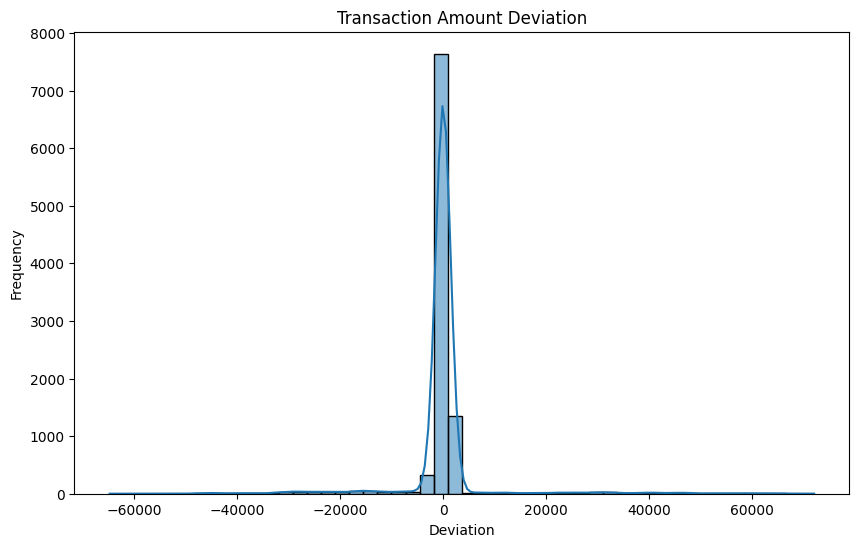

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df["txn_amount_deviation"], bins=50, kde=True)
plt.title("Transaction Amount Deviation")
plt.xlabel("Deviation")
plt.ylabel("Frequency")
plt.show()


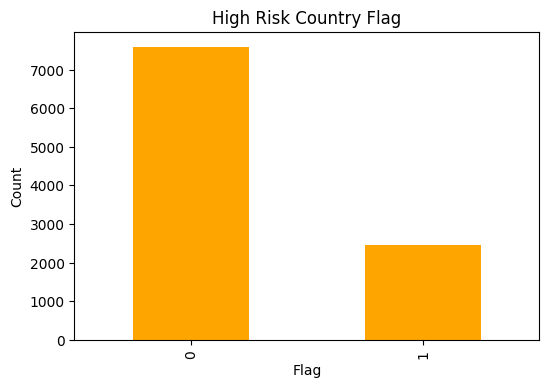

In [ ]:
plt.figure(figsize=(6,4))
df["is_high_risk_country"].value_counts().plot.bar(color="orange")
plt.title("High Risk Country Flag")
plt.xlabel("Flag")
plt.ylabel("Count")
plt.show()


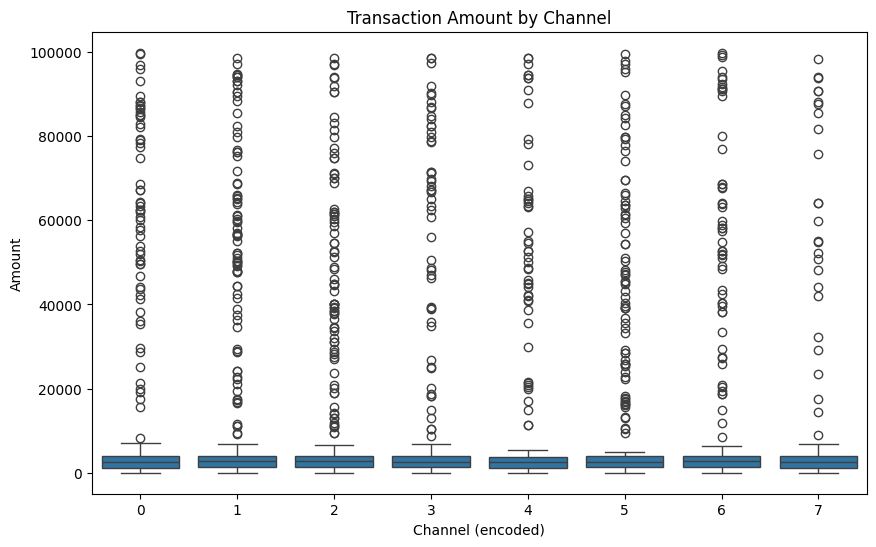

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x="channel", y="transaction_amount", data=df)
plt.title("Transaction Amount by Channel")
plt.xlabel("Channel (encoded)")
plt.ylabel("Amount")
plt.show()


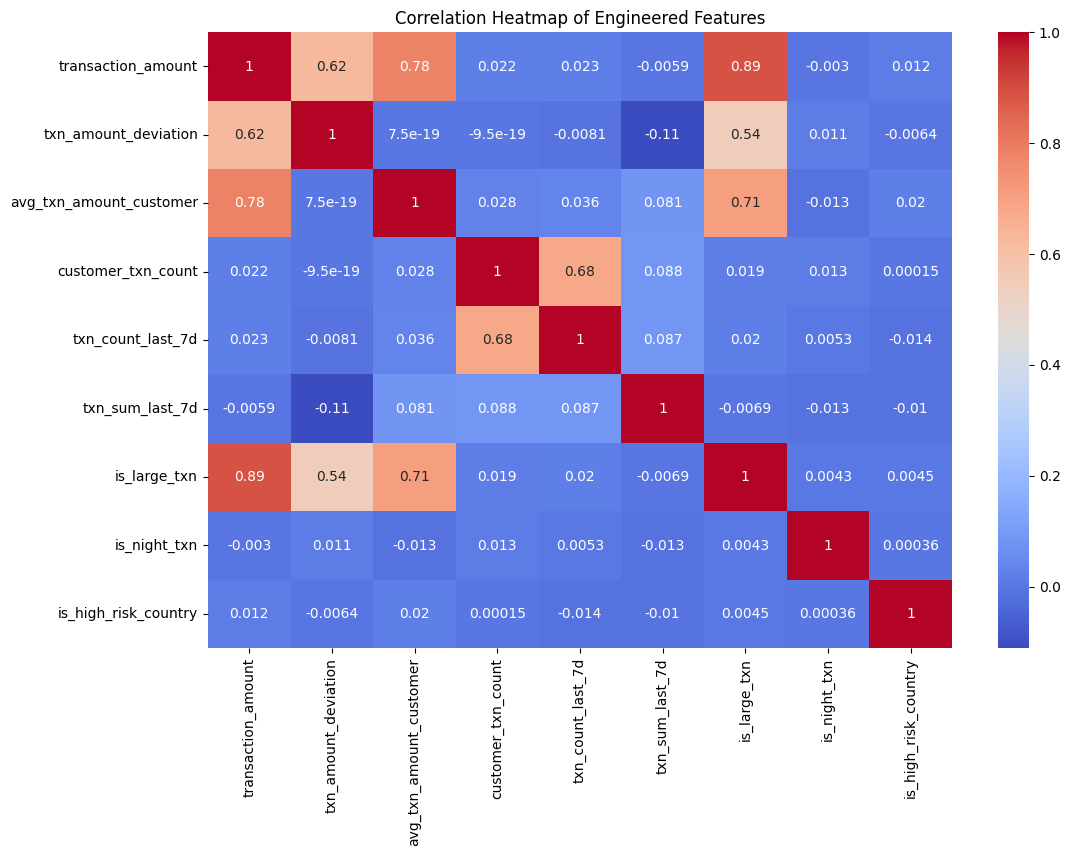

In [ ]:
corr_cols = [
    "transaction_amount",
    "txn_amount_deviation",
    "avg_txn_amount_customer",
    "customer_txn_count",
    "txn_count_last_7d",
    "txn_sum_last_7d",
    "is_large_txn",
    "is_night_txn",
    "is_high_risk_country"
]
plt.figure(figsize=(12,8))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Engineered Features")
plt.show()


Anomaly Detection

✅ Loaded data: (10050, 32)
✅ Isolation Forest complete.
✅ Isolation Forest results saved to /content/isolation_forest_results.csv
Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 1.0200 - val_loss: 0.9215
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8589 - val_loss: 0.8557
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.7952 - val_loss: 0.7619
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7043 - val_loss: 0.6976
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.6416 - val_loss: 0.6530
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5728 - val_loss: 0.6000
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4810 - val_loss: 0.5590
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5009 - val_loss: 0.5403
Epoch 9/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4973 - val_loss: 0.5251
Epoch 10/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.4202 - val_loss: 0.5197


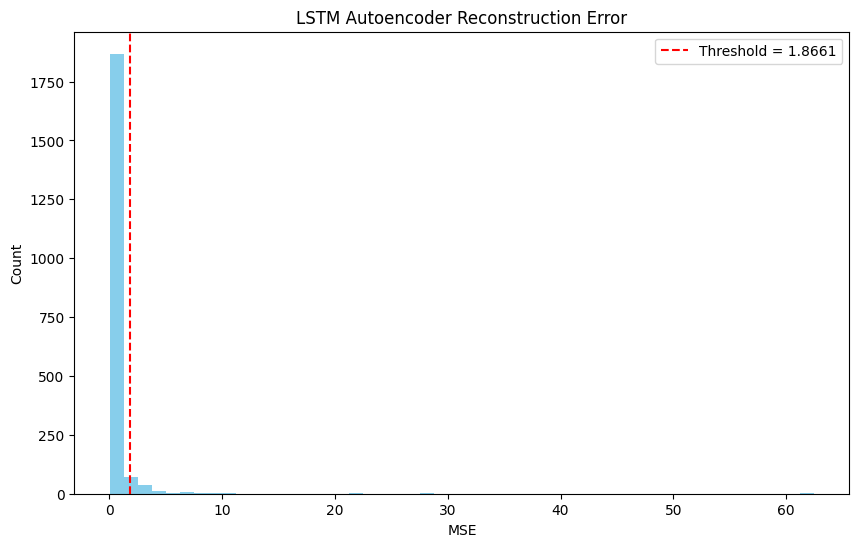

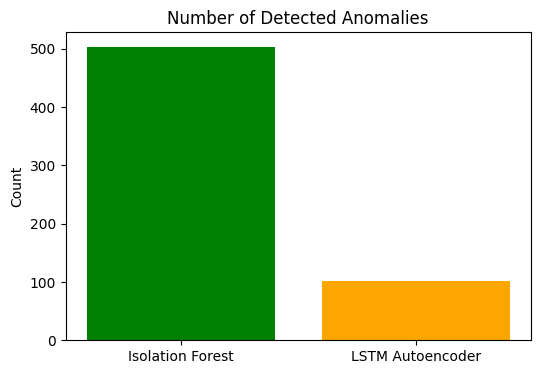

✅ LSTM Autoencoder results saved to /content/lstm_autoencoder_results.csv


,transaction_id,lstm_mse,lstm_anomaly
0,1416,0.356934,0
1,6098,1.074321,0
2,8220,0.057076,0
3,8928,1.914770,1
4,1705,0.056601,0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import seaborn as sns

# Load the feature-engineered dataset
df = pd.read_csv("/content/feature_engineered_transactions.csv", parse_dates=["transaction_time"])
print("✅ Loaded data:", df.shape)

# ===============================
# Prepare features for modeling
# ===============================

# Choose numeric features
features = [
    "transaction_amount",
    "txn_amount_deviation",
    "avg_txn_amount_customer",
    "customer_txn_count",
    "txn_count_last_7d",
    "txn_sum_last_7d",
    "is_large_txn",
    "is_night_txn",
    "is_high_risk_country"
]

X = df[features].fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ===============================
# 1️⃣ Isolation Forest
# ===============================
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_preds = iso_forest.fit_predict(X_scaled)

# Map predictions: -1 = anomaly, 1 = normal
df["iso_anomaly"] = (iso_preds == -1).astype(int)

print("✅ Isolation Forest complete.")

# Save Isolation Forest results
df[["transaction_id", "iso_anomaly"]].to_csv("/content/isolation_forest_results.csv", index=False)
print("✅ Isolation Forest results saved to /content/isolation_forest_results.csv")

# ===============================
# 2️⃣ LSTM Autoencoder
# ===============================

# Train-test split
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Reshape for LSTM
X_train_r = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_r = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM Autoencoder
inputs = layers.Input(shape=(X_train_r.shape[1], 1))
encoded = layers.LSTM(8, activation="relu")(inputs)
decoded = layers.RepeatVector(X_train_r.shape[1])(encoded)
decoded = layers.LSTM(8, activation="relu", return_sequences=True)(decoded)
outputs = layers.TimeDistributed(layers.Dense(1))(decoded)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer="adam", loss="mse")

# Train
history = autoencoder.fit(
    X_train_r, X_train_r,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Predict reconstructions
reconstructions = autoencoder.predict(X_test_r)
mse = np.mean(np.power(X_test_r - reconstructions, 2), axis=(1,2))

# Threshold
threshold = np.percentile(mse, 95)
lstm_preds = (mse > threshold).astype(int)

print("✅ LSTM Autoencoder complete.")

# ===============================
# Visualizations
# ===============================

# Plot Reconstruction Error Histogram
plt.figure(figsize=(10,6))
plt.hist(mse, bins=50, color="skyblue")
plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.4f}")
plt.title("LSTM Autoencoder Reconstruction Error")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.legend()
plt.show()

# Bar chart comparing anomaly counts
iso_count = df["iso_anomaly"].sum()
lstm_count = lstm_preds.sum()

plt.figure(figsize=(6,4))
plt.bar(["Isolation Forest", "LSTM Autoencoder"], [iso_count, lstm_count], color=["green","orange"])
plt.title("Number of Detected Anomalies")
plt.ylabel("Count")
plt.show()

# ===============================
# Save LSTM Results
# ===============================

# Build DataFrame for LSTM predictions
lstm_results_df = pd.DataFrame({
    "transaction_id": df.iloc[X_test_r[:,0,0].argsort()]["transaction_id"].values,
    "lstm_mse": mse,
    "lstm_anomaly": lstm_preds
})

lstm_results_df.to_csv("/content/lstm_autoencoder_results.csv", index=False)
print("✅ LSTM Autoencoder results saved to /content/lstm_autoencoder_results.csv")

# Display example rows
lstm_results_df.head()


Shap for reasoning

✅ SHAP explanations generated for Isolation Forest.


/tmp/ipython-input-16-4021777346.py:46: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_iso, X, plot_type="bar")


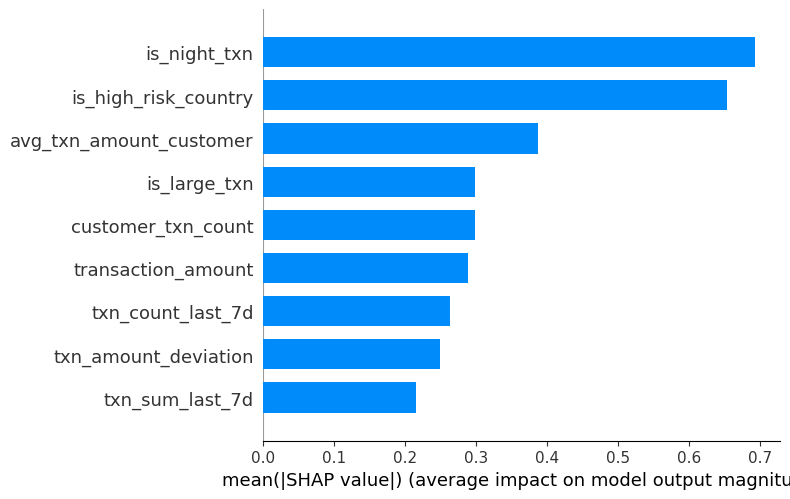

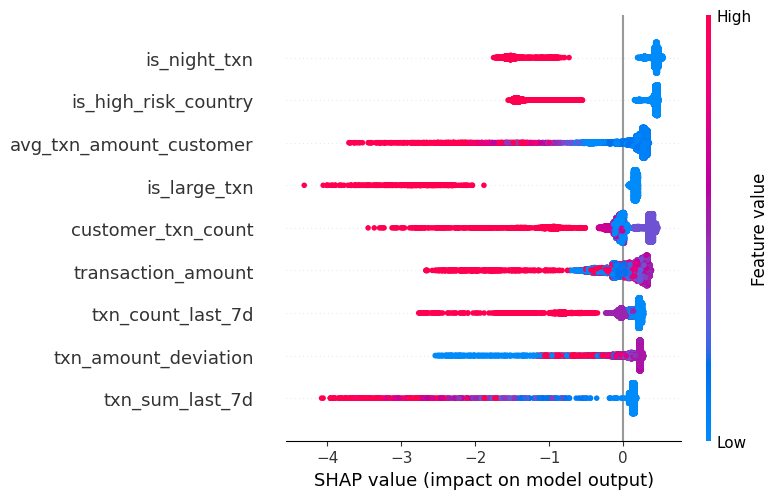

✅ Isolation Forest SHAP explanations saved to /content/isolation_forest_shap_explanations.csv


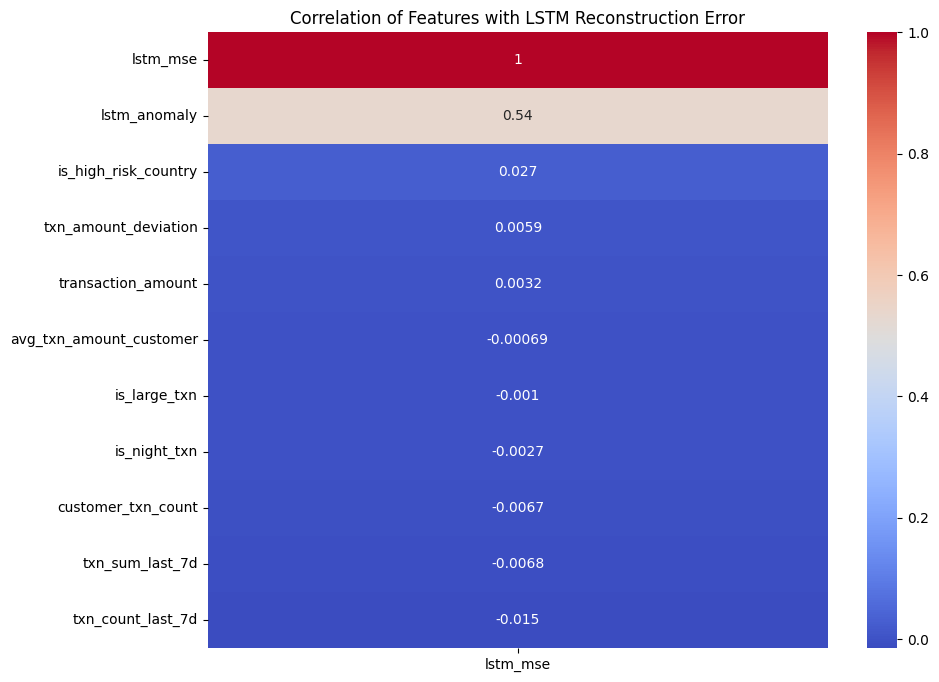

✅ LSTM Approximate explanations saved to /content/lstm_approx_explanations.csv


,transaction_id,lstm_anomaly,lstm_top_reasons
0,1,0.0,Not Anomalous
1,2,0.0,Not Anomalous
2,3,0.0,Not Anomalous
3,4,0.0,Not Anomalous
4,5,0.0,Not Anomalous


In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Load data and model inputs
df = pd.read_csv("/content/feature_engineered_transactions.csv")
iso_results = pd.read_csv("/content/isolation_forest_results.csv")
lstm_results = pd.read_csv("/content/lstm_autoencoder_results.csv")

# Choose the same numeric features used in modeling
features = [
    "transaction_amount",
    "txn_amount_deviation",
    "avg_txn_amount_customer",
    "customer_txn_count",
    "txn_count_last_7d",
    "txn_sum_last_7d",
    "is_large_txn",
    "is_night_txn",
    "is_high_risk_country"
]

X = df[features].fillna(0)

# ===============================
# SHAP for Isolation Forest
# ===============================

from sklearn.ensemble import IsolationForest

# Refit Isolation Forest on all data for SHAP consistency
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X)

explainer_iso = shap.Explainer(iso_forest)
shap_values_iso = explainer_iso(X)

print("✅ SHAP explanations generated for Isolation Forest.")

# ===============================
# Plot SHAP Summary for Isolation Forest
# ===============================

shap.summary_plot(shap_values_iso, X, plot_type="bar")
shap.summary_plot(shap_values_iso, X)

# ===============================
# Extract Top Features for Each Isolation Forest Anomaly
# ===============================

iso_anomalies = iso_results["iso_anomaly"].values
iso_top_reasons = []

feature_names = X.columns.tolist()

for i in range(len(X)):
    if iso_anomalies[i] == 1:
        shap_row = shap_values_iso[i]
        top_idx = np.argsort(-np.abs(shap_row.values))[:3]
        reasons = [feature_names[j] for j in top_idx]
        iso_top_reasons.append(", ".join(reasons))
    else:
        iso_top_reasons.append("Not Anomalous")

# Save to DataFrame
iso_explanations_df = pd.DataFrame({
    "transaction_id": df["transaction_id"],
    "iso_anomaly": iso_anomalies,
    "iso_top_reasons": iso_top_reasons
})

iso_explanations_df.to_csv("/content/isolation_forest_shap_explanations.csv", index=False)
print("✅ Isolation Forest SHAP explanations saved to /content/isolation_forest_shap_explanations.csv")

# ===============================
# Approximate Feature Importance for LSTM Reconstruction Error
# ===============================

# Merge MSE with original features
lstm_results_sorted = lstm_results.sort_values("transaction_id").reset_index(drop=True)
X_sorted = df.sort_values("transaction_id").reset_index(drop=True)

# Combine
lstm_combined = pd.concat([X_sorted[features], lstm_results_sorted[["lstm_mse","lstm_anomaly"]]], axis=1)

# Correlation heatmap as proxy for feature influence on reconstruction error
plt.figure(figsize=(10,8))
corr = lstm_combined.corr()
sns.heatmap(corr[["lstm_mse"]].sort_values("lstm_mse", ascending=False), annot=True, cmap="coolwarm")
plt.title("Correlation of Features with LSTM Reconstruction Error")
plt.show()

# Extract Top Reason per anomaly (based on correlation ranking)
corr_ranked_features = corr["lstm_mse"].abs().sort_values(ascending=False).index.tolist()[1:4]
lstm_top_reason_text = ", ".join(corr_ranked_features)

# Assign same top reasons for all anomalies (approximation)
lstm_top_reasons = [
    lstm_top_reason_text if row["lstm_anomaly"] == 1 else "Not Anomalous"
    for _, row in lstm_combined.iterrows()
]

lstm_explanations_df = pd.DataFrame({
    "transaction_id": X_sorted["transaction_id"],
    "lstm_anomaly": lstm_combined["lstm_anomaly"],
    "lstm_top_reasons": lstm_top_reasons
})

lstm_explanations_df.to_csv("/content/lstm_approx_explanations.csv", index=False)
print("✅ LSTM Approximate explanations saved to /content/lstm_approx_explanations.csv")

# Display samples
iso_explanations_df.head()
lstm_explanations_df.head()


Adaptive Rule generation

In [ ]:
import pandas as pd

# Load all necessary files
df = pd.read_csv("/content/feature_engineered_transactions.csv")
iso_explanations = pd.read_csv("/content/isolation_forest_shap_explanations.csv")
lstm_explanations = pd.read_csv("/content/lstm_approx_explanations.csv")

# Merge everything by transaction_id
merged = df.merge(
    iso_explanations[["transaction_id", "iso_anomaly", "iso_top_reasons"]],
    on="transaction_id"
).merge(
    lstm_explanations[["transaction_id", "lstm_anomaly", "lstm_top_reasons"]],
    on="transaction_id"
)

print("✅ Merged Data Shape:", merged.shape)

# Generate adaptive rules
adaptive_rules = []

for idx, row in merged.iterrows():
    rules = []
    if row["transaction_amount"] > 10000:
        rules.append("Large Transaction")
    if row["is_high_risk_country"] == 1:
        rules.append("High-Risk Country")
    if row["is_night_txn"] == 1:
        rules.append("Night Transaction")
    if row["txn_count_last_7d"] > 5:
        rules.append("High Frequency in 7d")
    if row["is_suspicious_combo"] == 1:
        rules.append("Suspicious Combo")
    if not rules:
        rules.append("No Rule Triggered")
    adaptive_rules.append(", ".join(rules))

merged["adaptive_rule"] = adaptive_rules

# Save final table
merged.to_csv("/content/anomalies_with_adaptive_rules.csv", index=False)
print("✅ Adaptive rules saved to /content/anomalies_with_adaptive_rules.csv")

# Display sample
merged_display = merged[
    ["transaction_id",
     "transaction_amount",
     "iso_anomaly",
     "iso_top_reasons",
     "lstm_anomaly",
     "lstm_top_reasons",
     "adaptive_rule"]
]

print("✅ Sample Table of Anomalies and Rules:")
display(merged_display.head(10))


✅ Merged Data Shape: (10350, 36)
✅ Adaptive rules saved to /content/anomalies_with_adaptive_rules.csv
✅ Sample Table of Anomalies and Rules:


,transaction_id,transaction_amount,iso_anomaly,iso_top_reasons,lstm_anomaly,lstm_top_reasons,adaptive_rule
0,939,803,0,Not Anomalous,0.0,Not Anomalous,High-Risk Country
1,4059,74920,1,"is_large_txn, transaction_amount, avg_txn_amou...",NaN,Not Anomalous,Large Transaction
2,1384,808,0,Not Anomalous,0.0,Not Anomalous,No Rule Triggered
3,9229,2035,0,Not Anomalous,NaN,Not Anomalous,Night Transaction
4,1951,2969,0,Not Anomalous,0.0,Not Anomalous,Night Transaction
5,3976,880,0,Not Anomalous,NaN,Not Anomalous,No Rule Triggered
6,7611,3959,0,Not Anomalous,NaN,Not Anomalous,Night Transaction
7,3047,2394,0,Not Anomalous,NaN,Not Anomalous,Night Transaction
8,8796,2257,0,Not Anomalous,NaN,Not Anomalous,Night Transaction
9,9457,1944,0,Not Anomalous,NaN,Not Anomalous,No Rule Triggered


In [ ]:
import pandas as pd

# Load everything
df = pd.read_csv("/content/feature_engineered_transactions.csv")
iso_explanations = pd.read_csv("/content/isolation_forest_shap_explanations.csv")
lstm_explanations = pd.read_csv("/content/lstm_approx_explanations.csv")

# Merge by transaction_id
merged = df.merge(
    iso_explanations[["transaction_id", "iso_anomaly", "iso_top_reasons"]],
    on="transaction_id"
).merge(
    lstm_explanations[["transaction_id", "lstm_anomaly", "lstm_top_reasons"]],
    on="transaction_id"
)

print("✅ Merged Data Shape:", merged.shape)

# Generate adaptive rules ONLY for anomalous records
adaptive_rules = []

for idx, row in merged.iterrows():
    if row["iso_anomaly"] == 0 and row["lstm_anomaly"] == 0:
        # Not anomalous in either model
        adaptive_rules.append("Not Anomalous")
        continue

    # If anomalous, build rules
    rules = []
    if row["transaction_amount"] > 10000:
        rules.append("Large Transaction")
    if row.get("is_high_risk_country", 0) == 1:
        rules.append("High-Risk Country")
    if row.get("is_night_txn", 0) == 1:
        rules.append("Night Transaction")
    if row.get("txn_count_last_7d", 0) > 5:
        rules.append("High Frequency in 7d")
    if row.get("is_suspicious_combo", 0) == 1:
        rules.append("Suspicious Combo")

    if not rules:
        rules.append("Anomalous but No Specific Rule Triggered")

    adaptive_rules.append(", ".join(rules))

merged["adaptive_rule"] = adaptive_rules

# Save final output
merged.to_csv("/content/anomalies_with_adaptive_rules.csv", index=False)
print("✅ Adaptive rules saved to /content/anomalies_with_adaptive_rules.csv")

# Display only anomalous rows
anomalous_only = merged[
    (merged["iso_anomaly"] == 1) | (merged["lstm_anomaly"] == 1)
][
    [
        "transaction_id",
        "transaction_amount",
        "iso_anomaly",
        "iso_top_reasons",
        "lstm_anomaly",
        "lstm_top_reasons",
        "adaptive_rule"
    ]
]

print("✅ Anomalous records with explanations and adaptive rules:")
display(anomalous_only.head(10))


✅ Merged Data Shape: (10350, 36)
✅ Adaptive rules saved to /content/anomalies_with_adaptive_rules.csv
✅ Anomalous records with explanations and adaptive rules:


,transaction_id,transaction_amount,iso_anomaly,iso_top_reasons,lstm_anomaly,lstm_top_reasons,adaptive_rule
1,4059,74920,1,"is_large_txn, transaction_amount, avg_txn_amou...",NaN,Not Anomalous,Large Transaction
26,7229,39060,1,"is_large_txn, avg_txn_amount_customer, transac...",NaN,Not Anomalous,Large Transaction
39,8448,11320,1,"is_large_txn, transaction_amount, is_high_risk...",NaN,Not Anomalous,"Large Transaction, High-Risk Country"
45,1400,3105,0,Not Anomalous,1.0,"lstm_anomaly, is_high_risk_country, txn_count_...",Anomalous but No Specific Rule Triggered
89,7437,44340,1,"is_large_txn, transaction_amount, avg_txn_amou...",NaN,Not Anomalous,"Large Transaction, High-Risk Country"
90,6983,4930,1,"txn_sum_last_7d, avg_txn_amount_customer, txn_...",NaN,Not Anomalous,High-Risk Country
95,3571,69440,1,"is_large_txn, transaction_amount, avg_txn_amou...",NaN,Not Anomalous,"Large Transaction, High-Risk Country"
110,4950,90440,1,"is_large_txn, transaction_amount, avg_txn_amou...",NaN,Not Anomalous,Large Transaction
111,6631,22340,1,"is_large_txn, avg_txn_amount_customer, txn_amo...",NaN,Not Anomalous,Large Transaction
138,1872,1689,0,Not Anomalous,1.0,"lstm_anomaly, is_high_risk_country, txn_count_...",Anomalous but No Specific Rule Triggered


In [ ]:
import pandas as pd

# Load datasets
df = pd.read_csv("/content/feature_engineered_transactions.csv")
iso_explanations = pd.read_csv("/content/isolation_forest_shap_explanations.csv")
lstm_explanations = pd.read_csv("/content/lstm_approx_explanations.csv")

# Merge by transaction_id
merged = df.merge(
    iso_explanations[["transaction_id", "iso_anomaly", "iso_top_reasons"]],
    on="transaction_id"
).merge(
    lstm_explanations[["transaction_id", "lstm_anomaly", "lstm_top_reasons"]],
    on="transaction_id"
)

print("✅ Merged Data Shape:", merged.shape)

# Generate adaptive rules
adaptive_rules = []

for idx, row in merged.iterrows():
    if row["iso_anomaly"] == 0 and row["lstm_anomaly"] == 0:
        # Not anomalous
        adaptive_rules.append("NA")
        continue

    # If anomalous, generate rules
    rules = []
    if row["transaction_amount"] > 10000:
        rules.append("Large Transaction")
    if row.get("is_high_risk_country", 0) == 1:
        rules.append("High-Risk Country")
    if row.get("is_night_txn", 0) == 1:
        rules.append("Night Transaction")
    if row.get("txn_count_last_7d", 0) > 5:
        rules.append("High Frequency in 7d")
    if row.get("is_suspicious_combo", 0) == 1:
        rules.append("Suspicious Combo")

    if not rules:
        rules.append("Anomalous but No Specific Rule Triggered")

    adaptive_rules.append(", ".join(rules))

merged["adaptive_rule"] = adaptive_rules

# Save final output
merged.to_csv("/content/anomalies_with_adaptive_rules.csv", index=False)
print("✅ Adaptive rules saved to /content/anomalies_with_adaptive_rules.csv")

# Display all records
display(
    merged[
        [
            "transaction_id",
            "transaction_amount",
            "iso_anomaly",
            "iso_top_reasons",
            "lstm_anomaly",
            "lstm_top_reasons",
            "adaptive_rule"
        ]
    ].head(10)
)


✅ Merged Data Shape: (10350, 36)
✅ Adaptive rules saved to /content/anomalies_with_adaptive_rules.csv


,transaction_id,transaction_amount,iso_anomaly,iso_top_reasons,lstm_anomaly,lstm_top_reasons,adaptive_rule
0,939,803,0,Not Anomalous,0.0,Not Anomalous,NA
1,4059,74920,1,"is_large_txn, transaction_amount, avg_txn_amou...",NaN,Not Anomalous,Large Transaction
2,1384,808,0,Not Anomalous,0.0,Not Anomalous,NA
3,9229,2035,0,Not Anomalous,NaN,Not Anomalous,Night Transaction
4,1951,2969,0,Not Anomalous,0.0,Not Anomalous,NA
5,3976,880,0,Not Anomalous,NaN,Not Anomalous,Anomalous but No Specific Rule Triggered
6,7611,3959,0,Not Anomalous,NaN,Not Anomalous,Night Transaction
7,3047,2394,0,Not Anomalous,NaN,Not Anomalous,Night Transaction
8,8796,2257,0,Not Anomalous,NaN,Not Anomalous,Night Transaction
9,9457,1944,0,Not Anomalous,NaN,Not Anomalous,Anomalous but No Specific Rule Triggered


✅ Loaded data: (10350, 37)


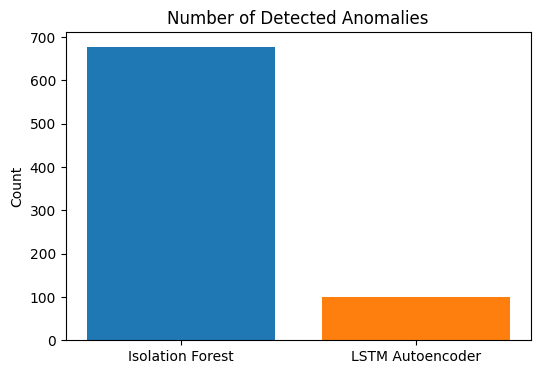

/tmp/ipython-input-20-414298720.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=rule_counts.index, x=rule_counts.values, palette="viridis")


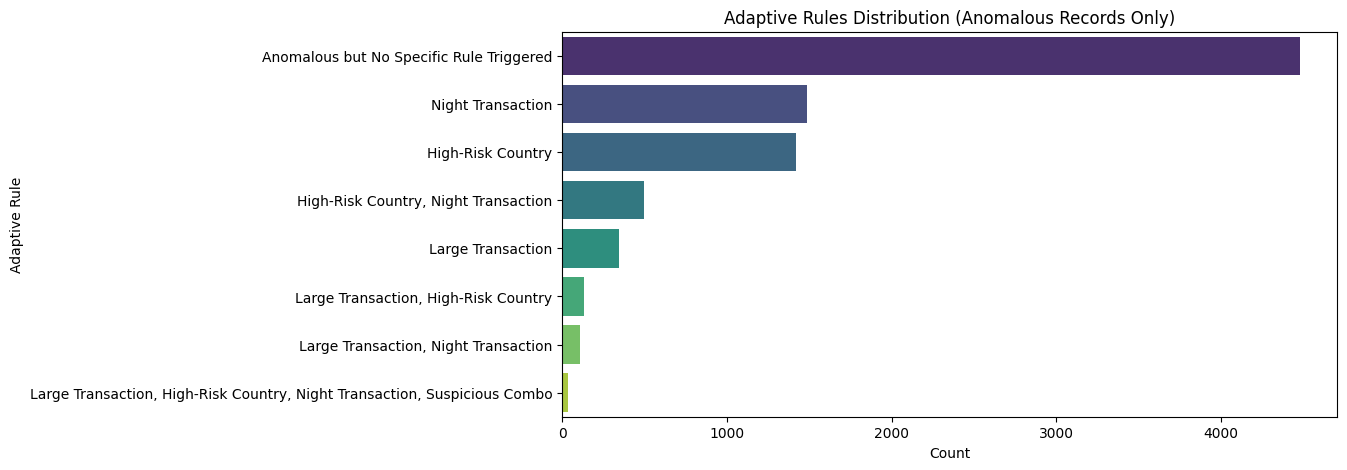

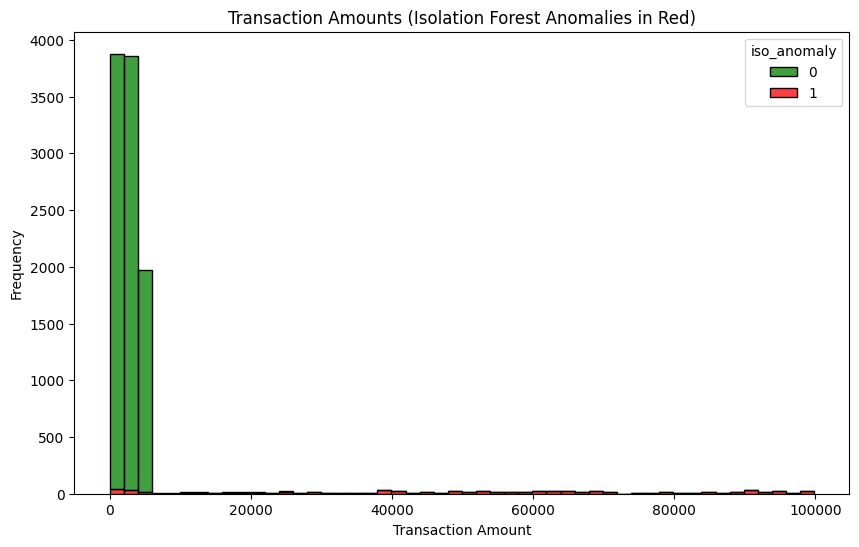

✅ Anomalous Transactions Table:


,transaction_id,transaction_amount,iso_anomaly,iso_top_reasons,lstm_anomaly,lstm_top_reasons,adaptive_rule
1,4059,74920,1,"is_large_txn, transaction_amount, avg_txn_amou...",NaN,Not Anomalous,Large Transaction
26,7229,39060,1,"is_large_txn, avg_txn_amount_customer, transac...",NaN,Not Anomalous,Large Transaction
39,8448,11320,1,"is_large_txn, transaction_amount, is_high_risk...",NaN,Not Anomalous,"Large Transaction, High-Risk Country"
45,1400,3105,0,Not Anomalous,1.0,"lstm_anomaly, is_high_risk_country, txn_count_...",Anomalous but No Specific Rule Triggered
89,7437,44340,1,"is_large_txn, transaction_amount, avg_txn_amou...",NaN,Not Anomalous,"Large Transaction, High-Risk Country"
90,6983,4930,1,"txn_sum_last_7d, avg_txn_amount_customer, txn_...",NaN,Not Anomalous,High-Risk Country
95,3571,69440,1,"is_large_txn, transaction_amount, avg_txn_amou...",NaN,Not Anomalous,"Large Transaction, High-Risk Country"
110,4950,90440,1,"is_large_txn, transaction_amount, avg_txn_amou...",NaN,Not Anomalous,Large Transaction
111,6631,22340,1,"is_large_txn, avg_txn_amount_customer, txn_amo...",NaN,Not Anomalous,Large Transaction
138,1872,1689,0,Not Anomalous,1.0,"lstm_anomaly, is_high_risk_country, txn_count_...",Anomalous but No Specific Rule Triggered


✅ Anomalies report saved to /content/anomalies_report.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load merged results
df = pd.read_csv("/content/anomalies_with_adaptive_rules.csv")

print("✅ Loaded data:", df.shape)

# ========================
# 1️⃣ Anomaly Counts
# ========================
iso_count = df["iso_anomaly"].sum()
lstm_count = df["lstm_anomaly"].sum()

plt.figure(figsize=(6,4))
plt.bar(["Isolation Forest", "LSTM Autoencoder"], [iso_count, lstm_count], color=["#1f77b4", "#ff7f0e"])
plt.title("Number of Detected Anomalies")
plt.ylabel("Count")
plt.show()

# ========================
# 2️⃣ Adaptive Rule Distribution
# ========================
plt.figure(figsize=(10,5))
rule_counts = df[df["adaptive_rule"] != "NA"]["adaptive_rule"].value_counts()
sns.barplot(y=rule_counts.index, x=rule_counts.values, palette="viridis")
plt.title("Adaptive Rules Distribution (Anomalous Records Only)")
plt.xlabel("Count")
plt.ylabel("Adaptive Rule")
plt.show()

# ========================
# 3️⃣ Transaction Amount Distribution
# ========================
plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x="transaction_amount",
    hue="iso_anomaly",
    bins=50,
    palette={0: "green", 1: "red"},
    multiple="stack"
)
plt.title("Transaction Amounts (Isolation Forest Anomalies in Red)")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

# ========================
# 4️⃣ Table of Anomalies
# ========================
anomalies_table = df[
    (df["iso_anomaly"]==1) | (df["lstm_anomaly"]==1)
][
    ["transaction_id", "transaction_amount", "iso_anomaly", "iso_top_reasons",
     "lstm_anomaly", "lstm_top_reasons", "adaptive_rule"]
]

print("✅ Anomalous Transactions Table:")
display(anomalies_table.head(10))

# ========================
# 5️⃣ Save Anomalies Report
# ========================
anomalies_table.to_csv("/content/anomalies_report.csv", index=False)
print("✅ Anomalies report saved to /content/anomalies_report.csv")


2025-07-03 11:36:13.196 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 11:36:13.197 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 11:36:13.387 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-03 11:36:13.398 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 11:36:13.403 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 11:36:13.406 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-03 11:36:13.406 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

False

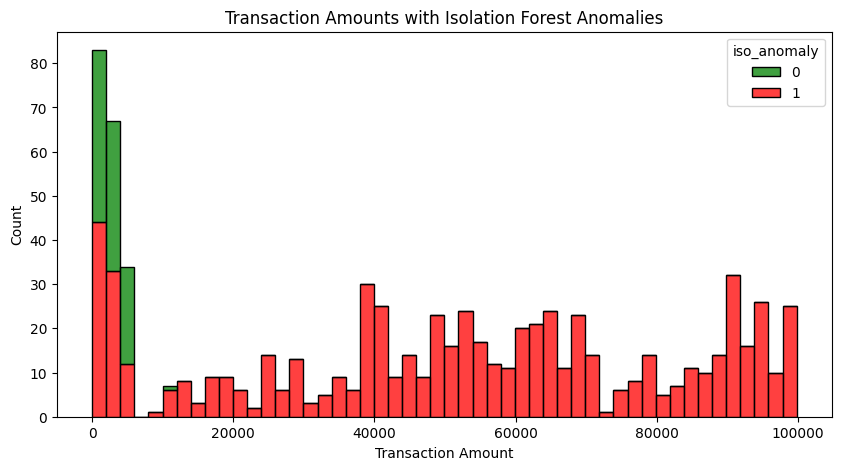

In [ ]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged results
df = pd.read_csv("/content/anomalies_with_adaptive_rules.csv")

st.set_page_config(page_title="Bank Transaction Anomaly Dashboard", layout="wide")

st.title("🚀 Bank Transaction Anomaly Detection Dashboard")

# ================================
# Sidebar Filters
# ================================
st.sidebar.header("🔍 Filters")

anomaly_filter = st.sidebar.multiselect(
    "Select Anomaly Type",
    ["Isolation Forest", "LSTM Autoencoder"],
    default=["Isolation Forest", "LSTM Autoencoder"]
)

rule_options = df["adaptive_rule"].unique().tolist()
if "NA" in rule_options:
    rule_options.remove("NA")
selected_rules = st.sidebar.multiselect(
    "Select Adaptive Rules",
    rule_options,
)

# ================================
# Filter Data
# ================================
filtered_df = df.copy()

if anomaly_filter:
    mask = pd.Series(False, index=filtered_df.index)
    if "Isolation Forest" in anomaly_filter:
        mask |= filtered_df["iso_anomaly"] == 1
    if "LSTM Autoencoder" in anomaly_filter:
        mask |= filtered_df["lstm_anomaly"] == 1
    filtered_df = filtered_df[mask]

if selected_rules:
    filtered_df = filtered_df[filtered_df["adaptive_rule"].isin(selected_rules)]

st.write(f"✅ Showing {len(filtered_df)} records.")

# ================================
# Anomaly Counts
# ================================
col1, col2 = st.columns(2)

with col1:
    iso_count = df["iso_anomaly"].sum()
    lstm_count = df["lstm_anomaly"].sum()
    st.metric("Isolation Forest Anomalies", iso_count)
    st.metric("LSTM Autoencoder Anomalies", lstm_count)

with col2:
    st.write("### Adaptive Rule Distribution")
    rule_counts = df[df["adaptive_rule"] != "NA"]["adaptive_rule"].value_counts()
    st.bar_chart(rule_counts)

# ================================
# Transaction Amount Distribution
# ================================
st.write("### Transaction Amount Distribution")
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    data=filtered_df,
    x="transaction_amount",
    hue="iso_anomaly",
    bins=50,
    multiple="stack",
    palette={0: "green", 1: "red"}
)
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.title("Transaction Amounts with Isolation Forest Anomalies")
st.pyplot(fig)

# ================================
# Table of Anomalies
# ================================
st.write("### Anomaly Details")
st.dataframe(
    filtered_df[
        [
            "transaction_id",
            "transaction_amount",
            "iso_anomaly",
            "iso_top_reasons",
            "lstm_anomaly",
            "lstm_top_reasons",
            "adaptive_rule"
        ]
    ]
)

# ================================
# Download Filtered Data
# ================================
csv = filtered_df.to_csv(index=False).encode()
st.download_button(
    label="Download Filtered Results as CSV",
    data=csv,
    file_name="filtered_anomalies.csv",
    mime="text/csv",
)
